In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt

In [74]:
#读取数据
df=pd.read_csv('./NI.csv',index_col=1)
df=df.drop(['ticker'],axis=1)
pd.set_option('display.max_rows',10)

In [76]:
#数据预处理
df['pct_chg_future']=df['pct_chg'].shift(-1)
df.loc[df['PVC'].isnull(),['PVC']]=0.

#tech index
df['MA10']=df['pct_chg'].rolling(10).mean()
df['MA20']=df['pct_chg'].rolling(20).mean()
df['MA60']=df['pct_chg'].rolling(60).mean()
df['abs_pct']=abs(df['pct_chg'])
df['ave_gain']=(df['abs_pct']+df['pct_chg']).rolling(60).mean()/2
df['ave_loss']=(df['abs_pct']-df['pct_chg']).rolling(60).mean()/2
df['RSI']=100-100/(1+df['ave_gain']/df['ave_loss'])

# 加入过去features
for i in range (4):
    df['L'+str(i+1)+'_open']=df['open'].shift(i+1)
    df['L'+str(i+1)+'_high']=df['high'].shift(i+1)
    df['L'+str(i+1)+'_low']=df['low'].shift(i+1)
    df['L'+str(i+1)+'_close']=df['close'].shift(i+1)
    df['L'+str(i+1)+'_volume']=df['volume'].shift(i+1)
    df['L'+str(i+1)+'_amt']=df['amt'].shift(i+1)
    df['L'+str(i+1)+'_pct_chg']=df['pct_chg'].shift(i+1)
for i in range (1):
    df['L'+str(i+1)+'_PVC']=df['PVC'].shift(i+1)
    df['L'+str(i+1)+'_SKW']=df['SKW'].shift(i+1)
    df['L'+str(i+1)+'_KTS']=df['KTS'].shift(i+1)
    df['L'+str(i+1)+'_SGH']=df['SGH'].shift(i+1)
    df['L'+str(i+1)+'_SR']=df['SR'].shift(i+1)
    df['L'+str(i+1)+'_VOL']=df['VOL'].shift(i+1)
    df['L'+str(i+1)+'_CSHSKW']=df['CSHSKW'].shift(i+1)
    df['L'+str(i+1)+'_CSHKTS']=df['CSHKTS'].shift(i+1)
    
df['F_low']=df['low'].shift(-1)
df['F_high']=df['high'].shift(-1)
df=df.dropna(axis='rows')
df=df.drop(['abs_pct','ave_gain','ave_loss'],axis=1)

In [77]:
df.to_pickle('./raw_data_reg.pkl')
df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'amt', 'pct_chg', 'PVC',
       'SKW', 'KTS', 'SGH', 'SR', 'VOL', 'CSHSKW', 'CSHKTS', 'pct_chg_future',
       'MA10', 'MA20', 'MA60', 'RSI', 'L1_open', 'L1_high', 'L1_low',
       'L1_close', 'L1_volume', 'L1_amt', 'L1_pct_chg', 'L2_open', 'L2_high',
       'L2_low', 'L2_close', 'L2_volume', 'L2_amt', 'L2_pct_chg', 'L3_open',
       'L3_high', 'L3_low', 'L3_close', 'L3_volume', 'L3_amt', 'L3_pct_chg',
       'L4_open', 'L4_high', 'L4_low', 'L4_close', 'L4_volume', 'L4_amt',
       'L4_pct_chg', 'L1_PVC', 'L1_SKW', 'L1_KTS', 'L1_SGH', 'L1_SR', 'L1_VOL',
       'L1_CSHSKW', 'L1_CSHKTS', 'F_low', 'F_high'],
      dtype='object')

In [78]:
df=pd.read_pickle('./raw_data_reg.pkl')

In [79]:
# #参数标准化
# df_array=np.array(df[['open', 'high', 'low', 'close', 'volume', 'amt', 'pct_chg', 'PVC',
#        'SKW', 'KTS', 'SGH', 'SR', 'VOL', 'CSHSKW', 'CSHKTS', 
#        'pct_chg_lag1', 'pct_chg_lag2', 'pct_chg_lag3', 'L_open', 'L_high',
#        'L_low', 'L_close', 'L_volume', 'L_amt', 'L_PVC', 'L_SKW', 'L_KTS',
#        'L_SGH', 'L_SR', 'L_VOL', 'L_CSHSKW', 'L_CSHKTS']])
# df_array=df_array/df_array.std(axis=0,keepdims=True)
# df[['open', 'high', 'low', 'close', 'volume', 'amt', 'pct_chg', 'PVC',
#        'SKW', 'KTS', 'SGH', 'SR', 'VOL', 'CSHSKW', 'CSHKTS', 
#        'pct_chg_lag1', 'pct_chg_lag2', 'pct_chg_lag3', 'L_open', 'L_high',
#        'L_low', 'L_close', 'L_volume', 'L_amt', 'L_PVC', 'L_SKW', 'L_KTS',
#        'L_SGH', 'L_SR', 'L_VOL', 'L_CSHSKW', 'L_CSHKTS']]=df_array
# df

In [80]:
df[['pct_chg','pct_chg_future']]

,pct_chg,pct_chg_future
TimeStamp,,
2017-01-05 00:30:00,0.000816,0.000233
2017-01-05 00:45:00,0.000233,-0.000466
2017-01-05 01:00:00,-0.000466,-0.001864
2017-01-05 09:15:00,-0.001864,-0.001167
2017-01-05 09:30:00,-0.001167,-0.001052
...,...,...
2019-03-29 23:45:00,0.000000,0.000099
2019-03-30 00:00:00,0.000099,-0.000395
2019-03-30 00:15:00,-0.000395,0.000988


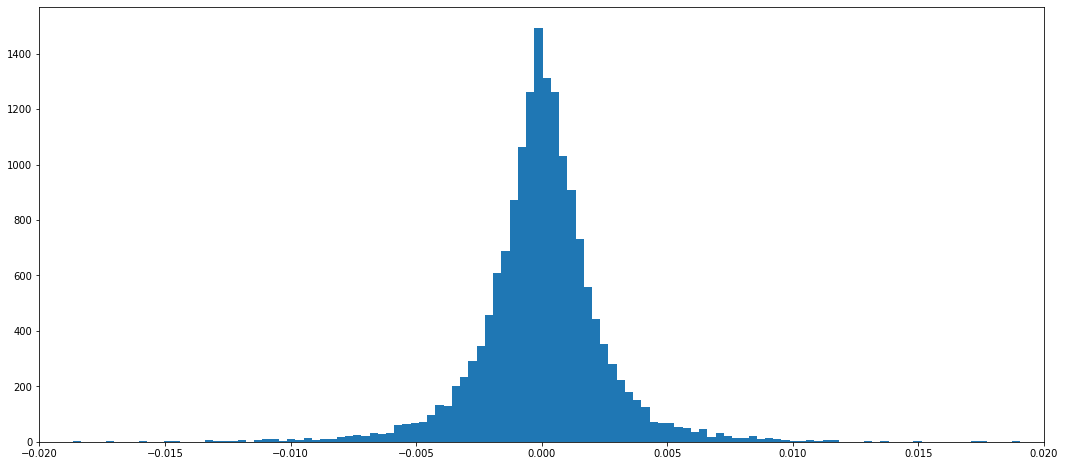

In [81]:
plt.figure(figsize=(18,8))
plt.hist(df['pct_chg_future'],200)
plt.xlim([-0.02,0.02])
plt.show()

In [82]:
#训练集
test_num=12000
train_data=lgb.Dataset(df.iloc[:test_num].drop(['pct_chg_future','F_low','F_high'],axis=1),
                       label=df.iloc[:test_num]['pct_chg_future'],free_raw_data=False)#categorical_feature=['**']

In [83]:
#测试集构造
test_x=df.iloc[test_num:].drop(['pct_chg_future','F_low','F_high'],axis=1)
test_y=df.iloc[test_num:][['pct_chg_future']]
test_y.head()

,pct_chg_future
TimeStamp,
2018-08-14 23:00:00,-0.001073
2018-08-14 23:15:00,0.001611
2018-08-14 23:30:00,-0.001251
2018-08-14 23:45:00,-0.002147
2018-08-15 00:00:00,-0.000448


In [84]:
#模型参数设置
param={'objective':'regression',
       'metric':'regression','max_depth':5,'boosting':'gbdt',
      'num_iterations':150,'num_leaves':31,'min_data_in_leaf':500,
      'lambda_l2':1.}#max_depth 防止过拟合；多酚类可以用'metric':'multi_logloss'
#'bagging_freq':5,'bagging_fraction':0.75,'tree_learner':'voting',

In [85]:
# lgb.cv(param,train_data, num_boost_round=100, nfold=10, early_stopping_rounds=90)

In [86]:
#模型拟合
num_round=800
bst=lgb.train(param,train_data,num_round)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


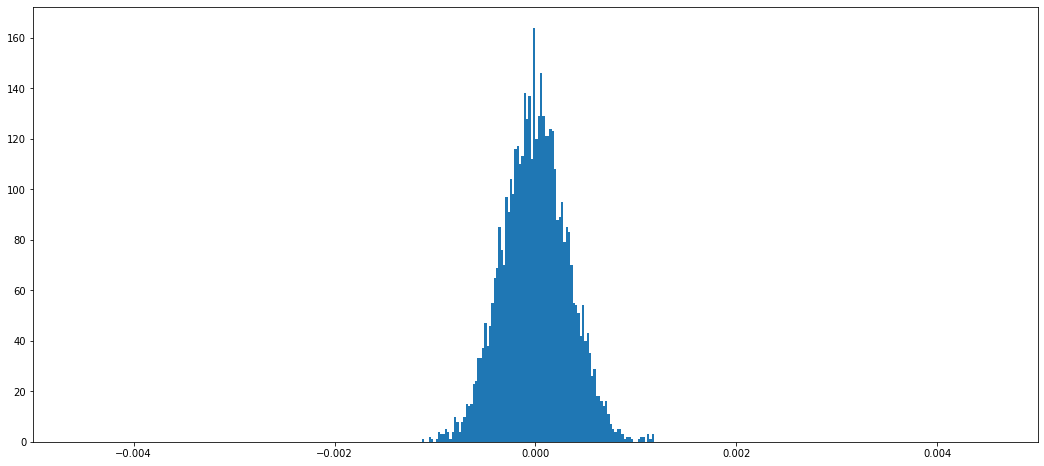

In [127]:
#模型预测
ypred=bst.predict(test_x)
plt.figure(figsize=(18,8))
plt.hist(ypred,100)
plt.xlim([-0.005,0.005])
plt.show()

In [128]:
test_y['predict']=np.array(ypred)
test_y['real_change']=np.nan
test_y.loc[test_y['pct_chg_future']>0,['real_change']]=1
test_y.loc[test_y['pct_chg_future']==0,['real_change']]=0
test_y.loc[test_y['pct_chg_future']<0,['real_change']]=-1

points=0.0006
test_y['pred_change']=np.nan
test_y.loc[test_y['predict']>points,['pred_change']]=1
test_y.loc[test_y['predict']<-points,['pred_change']]=-1
test_y.loc[(test_y['predict']>=-points)&(test_y['predict']<=points),['pred_change']]=0
test_y['pred_change']=test_y['pred_change'].astype(int)
test_y['real_change']=test_y['real_change'].astype(int)

test_y1=test_y.loc[test_y['pred_change']!=0]
test_y1

,pct_chg_future,predict,real_change,pred_change
TimeStamp,,,,
2018-08-14 23:00:00,-0.001073,0.001079,-1,1
2018-08-15 23:00:00,-0.000093,0.000749,-1,1
2018-08-16 21:30:00,0.000180,0.000623,1,1
2018-08-17 00:00:00,0.000724,-0.000654,1,-1
2018-08-17 14:00:00,-0.006765,-0.000740,-1,-1
...,...,...,...,...
2019-03-28 11:15:00,0.001392,-0.000714,1,-1
2019-03-28 21:45:00,0.001905,0.000907,1,1
2019-03-28 23:30:00,0.000401,0.000813,1,1


In [129]:
test_y1['real_change'].value_counts()/test_y1.shape[0]*100

 1    53.046595
-1    45.519713
 0     1.433692
Name: real_change, dtype: float64

In [130]:
#准确率估计
test_y1['accurate']=abs(test_y1['real_change']-test_y1['pred_change'])
test_y1['accurate']=test_y1['accurate'].astype(int)
test_y1.loc[test_y1['accurate']!=0,['accurate']]=-1
test_y1['accurate']=test_y1['accurate']+1
accurate_rate=test_y1['accurate'].value_counts()/test_y1.shape[0]*100
accurate_rate

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

1    58.422939
0    41.577061
Name: accurate, dtype: float64

In [131]:
y1=test_y1.drop(['pct_chg_future'],axis=1)
x=df.iloc[test_num:]
review=x.join(y1)
# review['accurate']=review['accurate'].astype(int)
# review['real_change']=review['real_change'].astype(int)
# review['pred_change']=review['pred_change'].astype(int)
review['action']=review['pred_change']
review.loc[~((review['action']>=-10)&(review['action']<=10)),['action']]=0
review['action']=review['action'].astype(int)
review[['pct_chg_future','action']]
# review['action'].value_counts()
review.columns
review.loc[(review['action']==1)&(review['F_low']>review['close']),['action']]=0
review.loc[(review['action']==-1)&(review['F_high']<review['close']),['action']]=0

In [132]:
#输出结果
output=pd.read_pickle('./raw_data_reg.pkl')
output=output[['open', 'high', 'low', 'close', 'volume', 'amt', 'pct_chg', 'PVC',
       'SKW', 'KTS', 'SGH', 'SR', 'VOL', 'CSHSKW', 'CSHKTS', 'pct_chg_future']]
output=output.join(review[['action']])
output=output.rename(columns={'action':'strategy'})
output['strategy'].value_counts()
output.to_csv('./output.csv')

In [119]:
rtn=(review['pct_chg_future']*review['action']).mean()*252*24
print('Return with no transaction fee:',rtn)

review['fee']=abs(review['action']-review['action'].shift(1))*0.01/100
rtn_actual=(review['pct_chg_future']*review['action']-review['fee']).mean()*252*24
print('Return after transaction fee:',rtn_actual)

std=(review['pct_chg_future']*review['action']).std()*((252*24)**0.5)
print('Standard deviation:',std)

Sharp_Ratio=(rtn_actual)/std
print('Sharp Ratio:',Sharp_Ratio)

print('N:',y1.shape[0])
# review['pct_chg_future'].mean()*252*24
# review['action'].value_counts()

Return with no transaction fee: 0.0998443863144219
Return after transaction fee: 0.03354707836257265
Standard deviation: 0.035870108390829464
Sharp Ratio: 0.9352377193024954
N: 279


In [120]:
cut_points=np.arange(0.00015,0.0010,0.00001)
rtn1=np.zeros(len(cut_points))
rtn_actual1=np.zeros(len(cut_points))
std1=np.zeros(len(cut_points))
SR1=np.zeros(len(cut_points))
x=df.iloc[test_num:]
for i in range(len(cut_points)):
    test_y['pred_change']=np.nan
    test_y.loc[test_y['predict']>cut_points[i],['pred_change']]=1
    test_y.loc[test_y['predict']<-cut_points[i],['pred_change']]=-1
    test_y.loc[(test_y['predict']>=-cut_points[i])&(test_y['predict']<=cut_points[i]),['pred_change']]=0
    test_y['pred_change']=test_y['pred_change'].astype(int)
    test_y['real_change']=test_y['real_change'].astype(int)
    test_y1=test_y.loc[test_y['pred_change']!=0]
    y1=test_y1.drop(['pct_chg_future'],axis=1)
    
    review=x.join(y1)
    review['action']=review['pred_change']
    review.loc[~((review['action']>=-10)&(review['action']<=10)),['action']]=0
    review['action']=review['action'].astype(int)
    review[['pct_chg_future','action']]
    review.loc[(review['action']==1)&(review['F_low']>review['close']),['action']]=0
    review.loc[(review['action']==-1)&(review['F_high']<review['close']),['action']]=0
    
    rtn1[i]=(review['pct_chg_future']*review['action']).mean()*252*24
    review['fee']=abs(review['action']-review['action'].shift(1))*0.01/100
    rtn_actual1[i]=(review['pct_chg_future']*review['action']-review['fee']).mean()*252*24
    std1[i]=(review['pct_chg_future']*review['action']).std()*((252*24)**0.5)
    SR1[i]=(rtn_actual1[i])/std1[i]

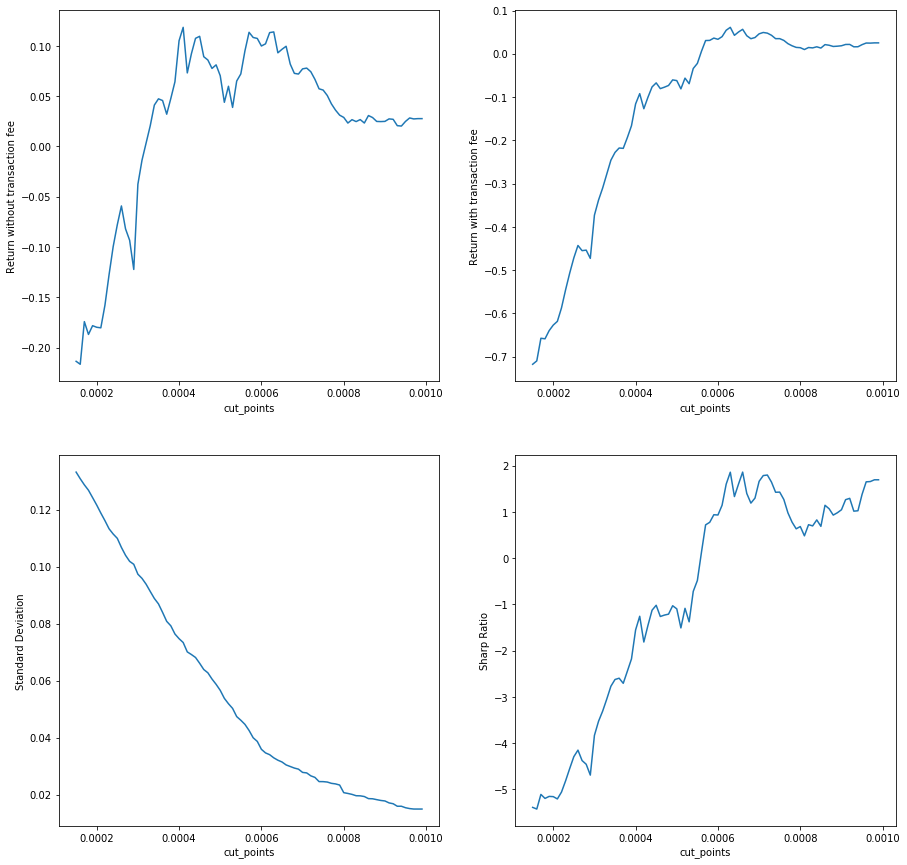

In [121]:
plt.figure(figsize=(15,15))
plt.subplot(221)
plt.plot(cut_points,rtn1)
plt.xlabel('cut_points')
plt.ylabel('Return without transaction fee')
plt.subplot(222)
plt.plot(cut_points,rtn_actual1)
plt.xlabel('cut_points')
plt.ylabel('Return with transaction fee')
plt.subplot(223)
plt.plot(cut_points,std1)
plt.xlabel('cut_points')
plt.ylabel('Standard Deviation')
plt.subplot(224)
plt.plot(cut_points,SR1)
plt.xlabel('cut_points')
plt.ylabel('Sharp Ratio')
plt.show()

In [122]:
y_train=df.iloc[:test_num][['pct_chg_future']]
x_train=df.iloc[:test_num].drop(['pct_chg_future'],axis=1)
ytrained=bst.predict(x_train)

y_train['predict']=np.array(ytrained)
y_train['real_change']=np.nan
y_train.loc[y_train['pct_chg_future']>0,['real_change']]=1
y_train.loc[y_train['pct_chg_future']==0,['real_change']]=0
y_train.loc[y_train['pct_chg_future']<0,['real_change']]=-1

points=0.00054
y_train['pred_change']=np.nan
y_train.loc[y_train['predict']>points,['pred_change']]=1
y_train.loc[y_train['predict']<-points,['pred_change']]=-1
y_train.loc[(y_train['predict']>=-points)&(y_train['predict']<=points),['pred_change']]=0
y_train['pred_change']=y_train['pred_change'].astype(int)
y_train['real_change']=y_train['real_change'].astype(int)

y_train1=y_train.loc[y_train['pred_change']!=0]

y_train1['real_change'].value_counts()/y_train1.shape[0]*100

 1    52.653548
-1    45.259392
 0     2.087060
Name: real_change, dtype: float64

In [123]:
y_train1['accurate']=abs(y_train1['real_change']-y_train1['pred_change'])
y_train1['accurate']=y_train1['accurate'].astype(int)
y_train1.loc[y_train1['accurate']!=0,['accurate']]=-1
y_train1['accurate']=y_train1['accurate']+1
accurate_rate_train=y_train1['accurate'].value_counts()/y_train1.shape[0]*100
accurate_rate_train

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

1    77.400119
0    22.599881
Name: accurate, dtype: float64